<a href="https://colab.research.google.com/github/MuhammadHammad-git/Voice-Recognition-Model-for-FYP-Trained-in-CNN-/blob/main/Optotype_Audio_Classification_FYP_VOICE_RECOGNITION_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing Data

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import sklearn

## Importing Audio Files and convertion into DATAFRAMES

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading Required Audio Recordings for each letter for training

In [ ]:
data_path = '/content/drive/MyDrive/Report-audios'

Creating dataframe with Columns the label like F T Z... and path to each training example for the letter

In [ ]:
data = pd.DataFrame(columns=['label', 'path'])

In [ ]:
for label in os.listdir(data_path):
    label_path = os.path.join(data_path, label)
    for filename in os.listdir(label_path):
        if filename.endswith('.wav'):
            filepath = os.path.join(label_path, filename)
            data = data.append({'label': label, 'path': filepath}, ignore_index=True)

data.to_csv('audio_data.csv', index=False)

In [ ]:

df = pd.read_csv('audio_data.csv')
df.head()

,label,path
0,F,/content/drive/MyDrive/Report-audios/F/PTT-202...
1,F,/content/drive/MyDrive/Report-audios/F/PTT-202...
2,F,/content/drive/MyDrive/Report-audios/F/PTT-202...
3,F,/content/drive/MyDrive/Report-audios/F/PTT-202...
4,F,/content/drive/MyDrive/Report-audios/F/PTT-202...


In [ ]:
df['label'].value_counts()

F    165
L    165
Z    165
O    165
Name: label, dtype: int64

Code for showing playable audio Wave using Librosa Library

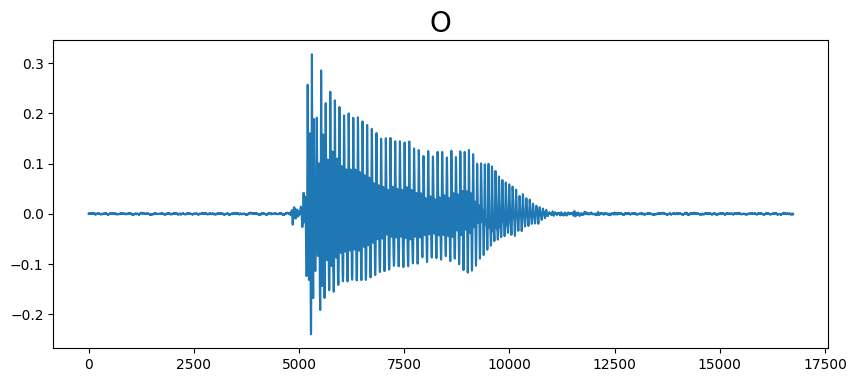

In [ ]:
optotype = 'O'
path = np.array(df['path'][df['label']==optotype])[33]
data, sampling_rate = librosa.load(path)
plt.figure(figsize=(10,4))
plt.title(optotype,size=20)
plt.plot(data)
plt.show()
Audio(path)

## EXTRACTING MFCC Values from each Audio Training Dataset

Creating coefficients in total 40, This was according ot research. The standard is 43 but 40 used here as it gave better accuracy!

In [ ]:

mfccs=librosa.feature.mfcc(y=data, sr=sampling_rate,n_mfcc=40)
print(mfccs.shape)

(40, 33)


In [ ]:
mfccs

array([[-5.8601477e+02, -5.6601672e+02, -5.6524988e+02, ...,
        -5.6939722e+02, -5.7134149e+02, -5.7493945e+02],
       [ 6.1842758e+01,  7.7694580e+01,  8.3814209e+01, ...,
         7.8311752e+01,  7.7488091e+01,  7.3913475e+01],
       [ 3.0088013e+01,  3.0300190e+01,  3.5993240e+01, ...,
         3.4817764e+01,  3.3772972e+01,  3.3007946e+01],
       ...,
       [-4.3664494e+00, -6.6189356e+00, -4.7775249e+00, ...,
         1.0310117e+00, -8.6472964e-01, -1.8828280e+00],
       [-2.1047945e+00, -5.2709136e+00, -6.0909557e+00, ...,
        -1.3165140e+00, -3.9587717e+00, -7.2100291e+00],
       [ 5.3846087e+00, -3.0636680e-01, -3.6146851e+00, ...,
        -1.7705622e+00, -4.9766879e+00, -6.5679221e+00]], dtype=float32)

In [ ]:
##Deploying CNN Model

Badding extra 0's at the end, so that all 40 coefficients are of the same length!

In [ ]:

max_pad_len = 85


X_mfcc = []
label1 = []

def extract_mfcc(file_name):
    audio, sample_rate = librosa.load(file_name)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    pad_width = max_pad_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    mfccs = (mfccs - np.mean(mfccs)) / np.std(mfccs)

    return mfccs


In [ ]:


X_mfcc = []
label1 = []

for i in range(len(df)):
    x = extract_mfcc(df['path'][i])
    X_mfcc.append(x)
    y = df['label'][i]
    label1.append(y)


In [ ]:
X_mfcc

Creating another dataframe with a features column containing the padded mfcc values and another column named class with label i.e. letters names.

In [ ]:
extracted_features_df= pd.DataFrame({'features': X_mfcc, 'class': label1})

In [ ]:
extracted_features_df.head(187)

In [ ]:
X=np.array(extracted_features_df['features'].tolist())
Y=np.array(extracted_features_df['class'].tolist())

Shape of the Input dataframe.

In [ ]:
X.shape

(660, 40, 85)

# LABEL ENCODING

In [ ]:
### Label Encoding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
Y=to_categorical(labelencoder.fit_transform(Y))


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

## Training the Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics

num_rows = 40
num_columns = 85
num_channels = 1

x_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
x_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

num_labels = 4

# Construct model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(num_labels, activation='softmax'))

In [ ]:

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
# Display model architecture summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 84, 16)        80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 42, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 42, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 41, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 20, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 20, 32)         0

# Fitting Model and Ploting Results

Epoch 1/100
17/17 [==============================] - 5s 184ms/step - loss: 1.3806 - accuracy: 0.2841 - val_loss: 1.3932 - val_accuracy: 0.2727
Epoch 2/100
17/17 [==============================] - 2s 125ms/step - loss: 1.3674 - accuracy: 0.3258 - val_loss: 1.3485 - val_accuracy: 0.3864
Epoch 3/100
17/17 [==============================] - 1s 85ms/step - loss: 1.3410 - accuracy: 0.3636 - val_loss: 1.3091 - val_accuracy: 0.4773
Epoch 4/100
17/17 [==============================] - 2s 89ms/step - loss: 1.2584 - accuracy: 0.4451 - val_loss: 1.1741 - val_accuracy: 0.5909
Epoch 5/100
17/17 [==============================] - 2s 89ms/step - loss: 1.0913 - accuracy: 0.5303 - val_loss: 1.0355 - val_accuracy: 0.5379
Epoch 6/100
17/17 [==============================] - 2s 89ms/step - loss: 0.9088 - accuracy: 0.6098 - val_loss: 0.8592 - val_accuracy: 0.6591
Epoch 7/100
17/17 [==============================] - 2s 89ms/step - loss: 0.8198 - accuracy: 0.6402 - val_loss: 1.0567 - val_accuracy: 0.5909
Epoc

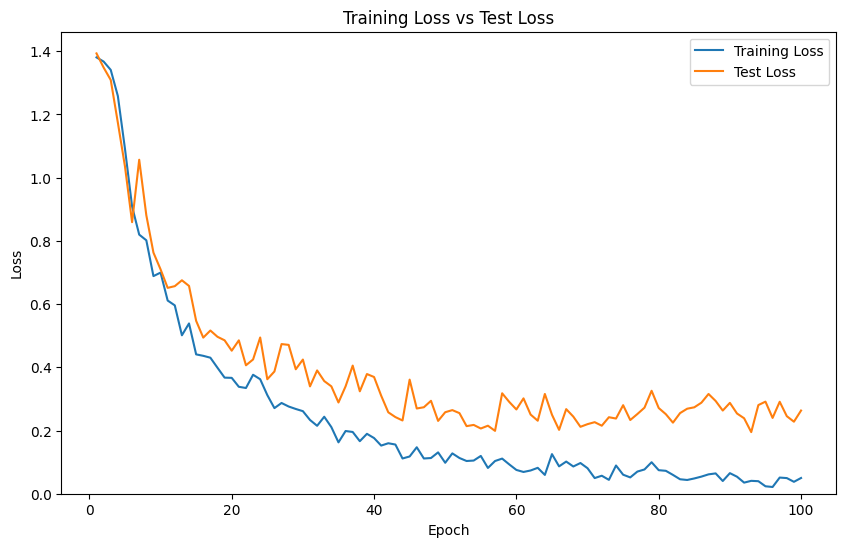

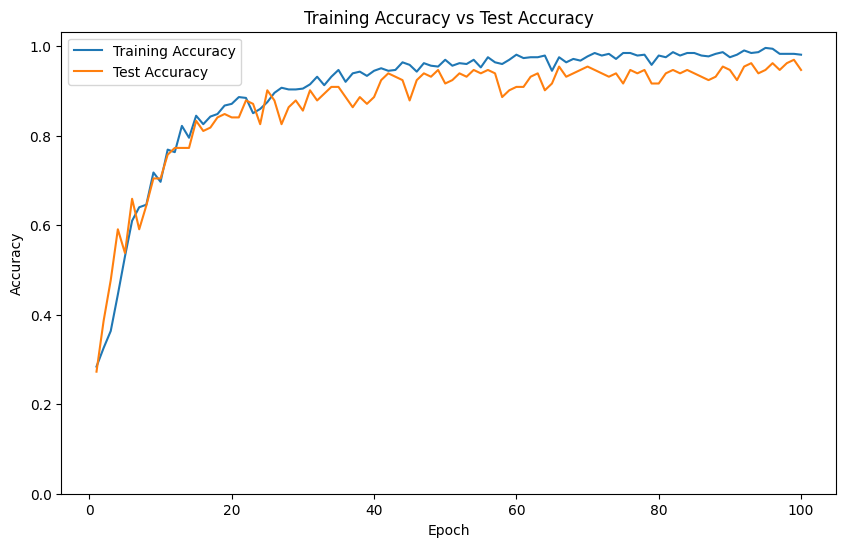

In [ ]:
import matplotlib.pyplot as plt

num_epochs = 100
num_batch_size = 32

history = model.fit(X_train, Y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, Y_test))

train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Test Loss')
plt.legend()
plt.ylim(bottom=0)  # Set y-axis to start from 0
plt.show()

# Plot training accuracy and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Test Accuracy')
plt.legend()
plt.ylim(bottom=0)  # Set y-axis to start from 0
plt.show()


## Training and Testing Accuracy

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(X_train, Y_train)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_test, Y_test)
print("Testing Accuracy: ", score[1])

17/17 [==============================] - 1s 34ms/step - loss: 0.0057 - accuracy: 1.0000
Training Accuracy:  1.0
5/5 [==============================] - 0s 29ms/step - loss: 0.3304 - accuracy: 0.9242
Testing Accuracy:  0.9242424368858337


## Prediction

In [ ]:
def print_prediction(file_name):
    prediction_feature = extract_mfcc(file_name)
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)
    predicted_vector = np.argmax(model.predict(prediction_feature),axis=-1)
    predicted_class = labelencoder.inverse_transform(predicted_vector)
    predicted_class
    print("The predicted class is:", predicted_class[0], '\n')



## Testing Prediction on different test Audio-dataset

In [ ]:
filename = 'F_TEST.wav'
print_prediction(filename)

1/1 [==============================] - 0s 33ms/step
The predicted class is: F 



In [ ]:
filename = 'Z_test.wav'
print_prediction(filename)

1/1 [==============================] - 0s 47ms/step
The predicted class is: Z 



In [ ]:
filename = 'O_test.wav'
print_prediction(filename)

1/1 [==============================] - 0s 47ms/step
The predicted class is: O 



In [ ]:
filename = 'L2test (2).wav'
print_prediction(filename)

1/1 [==============================] - 0s 90ms/step
The predicted class is: L 

